# 5900 Capstone Time Series Model - Exponential Smoothing Model - SureRide/Titan 65 

### Step 1: load packages

In [3]:
# load packages
library(ggplot2);library(ggthemes);library(gridExtra);library(dygraphs) # For plots 
library(quantmod);library(xts);library(zoo) # For converting data into xts class objects
library(fpp); library(fpp2) # Datasets from Forecasting text by Rob Hyndman
library(tseries) # for a statistical test
library(dplyr) # Data wrangling
library(caret) # Model Training
library(lubridate)

In [4]:
# Forecasting Tools
library(forecast) # Set of forecasting functions, including auto.arima

In [5]:
# Model Evaluation
# using the accuracy function in forecast package to provide model evaluation metrics, including ME, RMSE etc

### Step 2: read dataset

In [6]:
# 2019 order dataset
setwd('/Users/czw/Desktop')
order = read.csv("order19.csv") 
# pre-filtered dataset of items having price over 50
# transform the data type for order - 2019
order$Order.Qty=as.numeric(order$Order.Qty)
order$Order.Amount = as.numeric(order$Order.Amount)
order$Transaction.Date=as.Date(order$Transaction.Date, format='%m/%d/%Y')
order$Transaction.month=month(as.POSIXlt(order$Transaction.Date, format="%m/%d/%Y"))
order$Week.End.Date=as.Date(order$Week.End.Date, format='%m/%d/%Y')
order$Sub_Category_Family = as.factor(order$Sub_Category_Family)
# add a new column for unit price
order$unit_price = order$Order.Amount/order$Order.Qty 
# filter the dataset that only captures the items with unit price>$50
order = order %>%
    filter(order$unit_price>50)
head(order)

Company,Transaction.Date,Week.End.Date,Item,Item.Description,Category_Family,Category_Code,Sub_Category_Family,BRAND,Customer,...,Short.Close.Amount,Open.Qty,Open.Amount,Invoice.Qty,Invoice.Net.Amount,Invoice.Gross.Amount,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2019-01-01,2019-01-05,55411811,VIVE ELITE TS EMBRACE LINUS,Wheeled Goods,Travel Systems,Vive with Embrace,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,89.25
100,2019-01-01,2019-01-05,37112075,SURERIDE SPORT HARPER,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,72.00
100,2019-01-01,2019-01-05,34912204,MAESTRO SPORT WHITNEY,Car Seats,Booster,Maestro Sport,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,61.69
100,2019-01-01,2019-01-05,34812023,SONUS65 ROCCO RED,Car Seats,Convertible,Sonus,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,68.25
100,2019-01-01,2019-01-05,13812254,PIVOT XPAND STROLLER PERCHERON,Wheeled Goods,Strollers,Xpand,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,181.99
100,2019-01-01,2019-01-05,39212241,EVERYSTAGE DLX CANYONS,Car Seats,Convertible,Everystage,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,154.79


In [7]:
# 2018 order dataset
setwd('/Users/czw/Desktop')
order2=read.csv("order18.csv") 
# transform the data type for order - 2018
order2$Order.Qty=as.numeric(order2$Order.Qty)
order2$Order.Amount=as.numeric(order2$Order.Amount)
order2$Transaction.Date=as.Date(order2$Transaction.Date, format='%d-%B-%y')
order2$Transaction.month=month(as.POSIXlt(order2$Transaction.Date, format="%d-%B-%y"))
order2$Week.End.Date..EF.=as.Date(order2$Week.End.Date..EF., format='%d-%B-%y')
order2$Sub.Category = as.factor(order2$Sub.Category)
# add a new column for unit price
order2$unit_price = order2$Order.Amount/order2$Order.Qty
# filter the dataset that only captures the items with unit price>$50
order2 = order2 %>%
    filter(order2$unit_price>50)
head(order2)

Company,Transaction.Date,Week.End.Date..EF.,Item,Item.Description,Category.Family,Category,Sub.Category,Brand,Customer.ID,...,Open.Amount,Invoice.Qty,Invoice.Gross.Amount..HC.,Invoice.Net.Amount..HC.,Invoice.Gross.Amount..USD.,Invoice.Net.Amount..USD.,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2018-01-01,2018-01-06,1050500,TOP OF STAIR EXTRA TALL BOX,Gates,Wood Gates,105 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,138.73333
100,2018-01-01,2018-01-06,30512004,PROSERIES LTMX PORTLAND TWEED,Car Seats,Infant,Litemax,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,308.66667
100,2018-01-01,2018-01-06,34411927,SAFEMAX 3 IN 1 CRIMSON,Car Seats,Booster,Safemax,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,60.86667
100,2018-01-01,2018-01-06,4448100,EMBRACE WOOD & METAL GATE .COM,Gates,Metal Gates,105 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,212.66667
100,2018-01-01,2018-01-06,4449100,EMBRACE CLEAR PANEL GATE .COM,Gates,Metal Gates,448 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,212.66667
100,2018-01-01,2018-01-06,60511372,ZOO FRIENDS EXERSAUCER DLX,Activity,Activity Centers,Exersaucer Deluxe,Exersaucer,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,154.88889


### Step 3: Visualize the Historical Sales

In [8]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2019
# Editing whitespace out of levels
order$Sub_Category_Family = factor(trimws(order$Sub_Category_Family))
# subcategory 1: Sonus - 2019
order = order %>%
    filter(order$Sub_Category_Family == 'SureRide/Titan 65')
head(order)

Company,Transaction.Date,Week.End.Date,Item,Item.Description,Category_Family,Category_Code,Sub_Category_Family,BRAND,Customer,...,Short.Close.Amount,Open.Qty,Open.Amount,Invoice.Qty,Invoice.Net.Amount,Invoice.Gross.Amount,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2019-01-01,2019-01-05,37112075,SURERIDE SPORT HARPER,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,72
100,2019-01-01,2019-01-05,37112280,SURERIDE CARSON,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,72
100,2019-01-02,2019-01-05,37121334,SURERIDE DLX SUGAR PLUM,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,72
100,2019-01-03,2019-01-05,37121334,SURERIDE DLX SUGAR PLUM,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,0,0,0,3,216,216,0,0,1,72
100,2019-01-04,2019-01-05,37121334,SURERIDE DLX SUGAR PLUM,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,0,0,0,15,1080,1080,0,0,1,72
100,2019-01-04,2019-01-05,37112280,SURERIDE CARSON,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,72


In [9]:
# subcategory 1: Sonus - 2018
order2$Sub.Category= factor(trimws(order2$Sub.Category))
order2 = order2 %>%
    filter(order2$Sub.Category == 'SureRide/Titan 65')
head(order2)

Company,Transaction.Date,Week.End.Date..EF.,Item,Item.Description,Category.Family,Category,Sub.Category,Brand,Customer.ID,...,Open.Amount,Invoice.Qty,Invoice.Gross.Amount..HC.,Invoice.Net.Amount..HC.,Invoice.Gross.Amount..USD.,Invoice.Net.Amount..USD.,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2018-02-28,2018-03-03,37111746,SURERIDE DLX BERLIN,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,2,287.5333
100,2018-03-06,2018-03-10,37111746,SURERIDE DLX BERLIN,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,3,287.5333
100,2018-03-07,2018-03-10,37111746,SURERIDE DLX BERLIN,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,$ -,2,$ 145,144.90,$ 145,$ 145,0,$ -,3,287.5333
100,2018-03-08,2018-03-10,37111746,SURERIDE DLX BERLIN,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,$ -,1,$ 72,72.45,$ 72,$ 72,0,$ -,3,287.5333
100,2018-03-19,2018-03-24,37111723,SURERIDE DLX WINDSOR,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,3,276.0000
100,2018-03-22,2018-03-24,37111746,SURERIDE DLX BERLIN,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,$ -,1,$ 72,72.45,$ 72,$ 72,0,$ -,3,287.5333


In [10]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2019
days = order %>%
    group_by(Transaction.Date) %>%
    summarise(order_qty=sum(Order.Qty)) %>%
    mutate(transaction_month = month(Transaction.Date)) %>%
    mutate(transaction_year = year(Transaction.Date))
# convert numberic month to the abbreviation of month
days$transaction_month = month.abb[days$transaction_month]
head(days)

`summarise()` ungrouping output (override with `.groups` argument)



Transaction.Date,order_qty,transaction_month,transaction_year
2019-01-01,4,Jan,2019
2019-01-02,9,Jan,2019
2019-01-03,6,Jan,2019
2019-01-04,6,Jan,2019
2019-01-05,13,Jan,2019
2019-01-06,10,Jan,2019


In [11]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2018
days2 = order2 %>%
    group_by(Transaction.Date) %>%
    summarise(order_qty=sum(Order.Qty)) %>%
    mutate(transaction_month = month(Transaction.Date)) %>%
    mutate(transaction_year = year(Transaction.Date))
# convert numberic month to the abbreviation of month
days2$transaction_month = month.abb[days2$transaction_month]
head(days2)

`summarise()` ungrouping output (override with `.groups` argument)



Transaction.Date,order_qty,transaction_month,transaction_year
2018-02-28,15,Feb,2018
2018-03-06,15,Mar,2018
2018-03-07,15,Mar,2018
2018-03-08,15,Mar,2018
2018-03-19,15,Mar,2018
2018-03-22,15,Mar,2018


In [12]:
# merge the 2018-2019 days table
library(dplyr)
merge = rbind(days2,days)
head(merge)

Transaction.Date,order_qty,transaction_month,transaction_year
2018-02-28,15,Feb,2018
2018-03-06,15,Mar,2018
2018-03-07,15,Mar,2018
2018-03-08,15,Mar,2018
2018-03-19,15,Mar,2018
2018-03-22,15,Mar,2018


In [13]:
ts1 = xts(x= merge$order_qty, order.by = as.Date(merge$Transaction.Date, format='%Y/%m/%d'))
# dygraph(ts1,main="Historical Sales in 2018-2019 - Sonus",xlab="Date",ylab="Daily order quantity")

### Step4: Group by month and generate the ts format

In [14]:
# group by month
months = merge%>%
    group_by(month=floor_date(Transaction.Date, "month")) %>%
   summarize(order.sum=sum(order_qty))
months
# transform to ts
sales_ts = ts(months$order.sum, freq = 12, start = c(2018, 1), end = c(2019, 12))
print(sales_ts)

`summarise()` ungrouping output (override with `.groups` argument)



month,order.sum
2018-02-01,15
2018-03-01,90
2018-04-01,30
2018-05-01,30
2018-06-01,120
2018-07-01,105
2018-08-01,15
2018-10-01,90
2018-11-01,45
2018-12-01,150


      Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
2018   15   90   30   30  120  105   15   90   45  150 1632 1492
2019  875  973  887 1052  897  723  724  410  977 1090   15   90


### Step 5: split data into train and test

In [15]:
train=window(sales_ts,end=c(2019,3))
test=window(sales_ts,start=c(2019,4))
length(sales_ts) #24
length(train) #15
length(test) #9

[1] 24

[1] 15

[1] 9

### Step6: Exponential Smoothing Model Construction on test

In [16]:
# Simple Exponential Smoothing Model on test
library(forecast)
ses_model = ses(train,h=9,alpha=0.1, initial="simple")
ses_model

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Apr 2019       494.9465 -243.1105 1233.004 -633.8143 1623.707
May 2019       494.9465 -246.7916 1236.685 -639.4441 1629.337
Jun 2019       494.9465 -250.4546 1240.348 -645.0461 1634.939
Jul 2019       494.9465 -254.0996 1243.993 -650.6206 1640.514
Aug 2019       494.9465 -257.7269 1247.620 -656.1682 1646.061
Sep 2019       494.9465 -261.3369 1251.230 -661.6892 1651.582
Oct 2019       494.9465 -264.9297 1254.823 -667.1839 1657.077
Nov 2019       494.9465 -268.5056 1258.399 -672.6528 1662.546
Dec 2019       494.9465 -272.0649 1261.958 -678.0962 1667.989

In [17]:
# Holt's methods with damping on test
holt_damp_model = holt(train, h = 9, damped = T)
holt_damp_model

         Point Forecast      Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019       902.0920  243.67632 1560.508  -104.8679 1909.052
May 2019       908.8133   19.23103 1798.396  -451.6854 2269.312
Jun 2019       915.4001 -156.64462 1987.445  -724.1508 2554.951
Jul 2019       921.8552 -305.85799 2149.568  -955.7701 2799.480
Aug 2019       928.1812 -437.59858 2293.961 -1160.5987 3016.961
Sep 2019       934.3806 -556.76068 2425.522 -1346.1232 3214.884
Oct 2019       940.4561 -666.31783 2547.230 -1516.8926 3397.805
Nov 2019       946.4100 -768.23656 2661.057 -1675.9156 3568.736
Dec 2019       952.2449 -863.89733 2768.387 -1825.3050 3729.795

In [18]:
# Try to capture the seasonality, but not sufficient observations
# Holt - winter seasonal method
hw_additive = hw(train, h = 9, seasonal = 'additive', damped = T)
hw_additive

Warning message in ets(x, "AAA", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Not enough data to use damping”
Warning message in ets(x, "AAA", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Seasonal component could not be estimated”


         Point Forecast     Lo 80    Hi 80    Lo 95    Hi 95
Apr 2019       1108.746  574.0806 1643.411 291.0459 1926.446
May 2019       1183.746  647.1100 1720.382 363.0322 2004.459
Jun 2019       1258.746  720.1467 1797.345 435.0295 2082.462
Jul 2019       1333.746  793.1905 1874.301 507.0377 2160.454
Aug 2019       1408.746  866.2413 1951.250 579.0567 2238.435
Sep 2019       1483.746  939.2991 2028.193 651.0864 2316.405
Oct 2019       1558.746 1012.3638 2105.128 723.1267 2394.365
Nov 2019       1633.746 1085.4354 2182.056 795.1774 2472.314
Dec 2019       1708.746 1158.5137 2258.978 867.2384 2550.253

In [19]:
# Holt - winter Multiplicative
hw_multiplicative =  hw(train, h=9, seasonal = 'multiplicative', damped = T)
hw_multiplicative

Warning message in ets(x, "MAM", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Not enough data to use damping”
Warning message in ets(x, "MAM", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Seasonal component could not be estimated”


         Point Forecast     Lo 80    Hi 80    Lo 95    Hi 95
Apr 2019       1108.746  574.0806 1643.411 291.0459 1926.446
May 2019       1183.746  647.1100 1720.382 363.0322 2004.459
Jun 2019       1258.746  720.1467 1797.345 435.0295 2082.462
Jul 2019       1333.746  793.1905 1874.301 507.0377 2160.454
Aug 2019       1408.746  866.2413 1951.250 579.0567 2238.435
Sep 2019       1483.746  939.2991 2028.193 651.0864 2316.405
Oct 2019       1558.746 1012.3638 2105.128 723.1267 2394.365
Nov 2019       1633.746 1085.4354 2182.056 795.1774 2472.314
Dec 2019       1708.746 1158.5137 2258.978 867.2384 2550.253

### Step7: Model Forecast Visualization

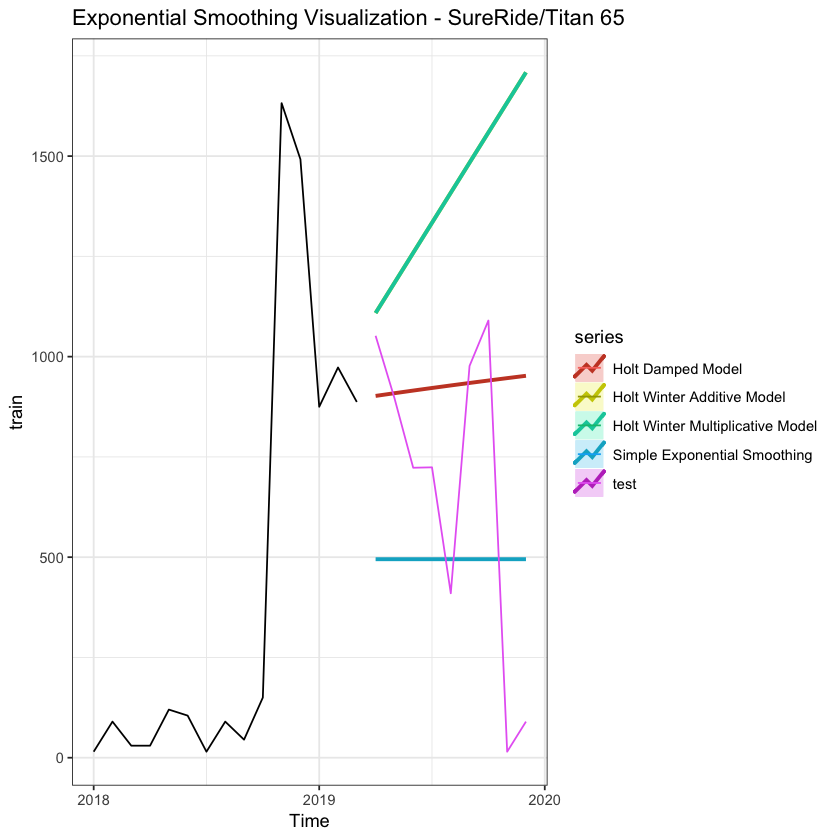

In [20]:
# Visualize forecasts (train & test)
autoplot(train)+
    autolayer(ses_model,series  = 'Simple Exponential Smoothing',PI = F, size = 1.1) +
    autolayer(holt_damp_model, series = 'Holt Damped Model', PI = F, size = 1.1)+
    autolayer(hw_additive, series = 'Holt Winter Additive Model', PI =F, size = 1.1)+
    autolayer(hw_multiplicative, series = 'Holt Winter Multiplicative Model', PI = F, size=1.1)+
labs(title="Exponential Smoothing Visualization - SureRide/Titan 65")+
    autolayer(test)+theme_bw()

### Step8: Obtain the forecast Value

In [21]:
# obtain predicted value
ses_forecast = forecast(ses_model,h=9)
holt_forecast = forecast(holt_damp_model, h = 9)
hw_additive_forecast = forecast(hw_additive,h=9)
hw_multiplicative_forecast = forecast(hw_multiplicative,h=9)

In [22]:
ses_forecast

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Apr 2019       494.9465 -243.1105 1233.004 -633.8143 1623.707
May 2019       494.9465 -246.7916 1236.685 -639.4441 1629.337
Jun 2019       494.9465 -250.4546 1240.348 -645.0461 1634.939
Jul 2019       494.9465 -254.0996 1243.993 -650.6206 1640.514
Aug 2019       494.9465 -257.7269 1247.620 -656.1682 1646.061
Sep 2019       494.9465 -261.3369 1251.230 -661.6892 1651.582
Oct 2019       494.9465 -264.9297 1254.823 -667.1839 1657.077
Nov 2019       494.9465 -268.5056 1258.399 -672.6528 1662.546
Dec 2019       494.9465 -272.0649 1261.958 -678.0962 1667.989

In [23]:
holt_forecast

         Point Forecast      Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019       902.0920  243.67632 1560.508  -104.8679 1909.052
May 2019       908.8133   19.23103 1798.396  -451.6854 2269.312
Jun 2019       915.4001 -156.64462 1987.445  -724.1508 2554.951
Jul 2019       921.8552 -305.85799 2149.568  -955.7701 2799.480
Aug 2019       928.1812 -437.59858 2293.961 -1160.5987 3016.961
Sep 2019       934.3806 -556.76068 2425.522 -1346.1232 3214.884
Oct 2019       940.4561 -666.31783 2547.230 -1516.8926 3397.805
Nov 2019       946.4100 -768.23656 2661.057 -1675.9156 3568.736
Dec 2019       952.2449 -863.89733 2768.387 -1825.3050 3729.795

In [24]:
hw_additive_forecast

         Point Forecast     Lo 80    Hi 80    Lo 95    Hi 95
Apr 2019       1108.746  574.0806 1643.411 291.0459 1926.446
May 2019       1183.746  647.1100 1720.382 363.0322 2004.459
Jun 2019       1258.746  720.1467 1797.345 435.0295 2082.462
Jul 2019       1333.746  793.1905 1874.301 507.0377 2160.454
Aug 2019       1408.746  866.2413 1951.250 579.0567 2238.435
Sep 2019       1483.746  939.2991 2028.193 651.0864 2316.405
Oct 2019       1558.746 1012.3638 2105.128 723.1267 2394.365
Nov 2019       1633.746 1085.4354 2182.056 795.1774 2472.314
Dec 2019       1708.746 1158.5137 2258.978 867.2384 2550.253

In [25]:
hw_multiplicative_forecast

         Point Forecast     Lo 80    Hi 80    Lo 95    Hi 95
Apr 2019       1108.746  574.0806 1643.411 291.0459 1926.446
May 2019       1183.746  647.1100 1720.382 363.0322 2004.459
Jun 2019       1258.746  720.1467 1797.345 435.0295 2082.462
Jul 2019       1333.746  793.1905 1874.301 507.0377 2160.454
Aug 2019       1408.746  866.2413 1951.250 579.0567 2238.435
Sep 2019       1483.746  939.2991 2028.193 651.0864 2316.405
Oct 2019       1558.746 1012.3638 2105.128 723.1267 2394.365
Nov 2019       1633.746 1085.4354 2182.056 795.1774 2472.314
Dec 2019       1708.746 1158.5137 2258.978 867.2384 2550.253

### Step 9: Exponential Smoothing Model on the whole dataset

In [26]:
# Simple Exponential Smoothing Model on the whole dataset
library(forecast)
ses_model_all = ses(sales_ts,alpha=0.1, initial="simple")
ses_model_all

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020       557.8789 -111.5193 1227.277 -465.8772 1581.635
Feb 2020       557.8789 -114.8579 1230.616 -470.9833 1586.741
Mar 2020       557.8789 -118.1801 1233.938 -476.0641 1591.822
Apr 2020       557.8789 -121.4860 1237.244 -481.1201 1596.878
May 2020       557.8789 -124.7760 1240.534 -486.1516 1601.909
Jun 2020       557.8789 -128.0501 1243.808 -491.1590 1606.917
Jul 2020       557.8789 -131.3087 1247.066 -496.1425 1611.900
Aug 2020       557.8789 -134.5519 1250.310 -501.1027 1616.860
Sep 2020       557.8789 -137.7801 1253.538 -506.0397 1621.797
Oct 2020       557.8789 -140.9933 1256.751 -510.9539 1626.712

In [27]:
# Holt's methods with damping on the whole dataset
holt_damp_model_all = holt(sales_ts,damped = T)
holt_damp_model_all

         Point Forecast      Lo 80     Hi 80      Lo 95    Hi 95
Jan 2020       155.3952  -448.0247  758.8151  -767.4559 1078.246
Feb 2020       157.0672  -582.8523  896.9868  -974.5421 1288.677
Mar 2020       158.6328  -696.2892 1013.5548 -1148.8575 1466.123
Apr 2020       160.0987  -796.1150 1116.3125 -1302.3040 1622.501
May 2020       161.4713  -886.3061 1209.2488 -1440.9660 1763.909
Jun 2020       162.7566  -969.2186 1294.7317 -1568.4500 1893.963
Jul 2020       163.9600 -1046.3840 1374.3039 -1687.1014 2015.021
Aug 2020       165.0867 -1118.8642 1449.0377 -1798.5468 2128.720
Sep 2020       166.1418 -1187.4306 1519.7142 -1903.9685 2236.252
Oct 2020       167.1297 -1252.6643 1586.9236 -2004.2578 2338.517

In [28]:
# Try to capture the seasonality, but not sufficient observations
# Holt - winter seasonal method
hw_additive_all = hw(sales_ts,seasonal = 'additive', damped = T)
hw_additive_all

         Point Forecast     Lo 80     Hi 80     Lo 95     Hi 95
Jan 2020      -996.7738 -2292.968  299.4206 -2979.132  985.5844
Feb 2020      -867.4641 -2489.573  754.6452 -3348.266 1613.3379
Mar 2020      -962.3710 -2855.236  930.4941 -3857.258 1932.5164
Apr 2020      -996.5563 -3126.144 1133.0318 -4253.480 2260.3676
May 2020      -942.7007 -3285.305 1399.9035 -4525.405 2640.0033
Jun 2020      -992.3833 -3530.262 1545.4956 -4873.734 2888.9675
Jul 2020     -1116.8448 -3836.073 1602.3830 -5275.545 3041.8552
Aug 2020     -1078.3557 -3967.623 1810.9112 -5497.108 3340.3967
Sep 2020     -1155.1668 -4205.049 1894.7155 -5819.559 3509.2257
Oct 2020     -1081.8698 -4284.357 2120.6174 -5979.651 3815.9116
Nov 2020       350.7127 -2997.460 3698.8853 -4769.875 5471.3008
Dec 2020       183.4192 -3304.383 3671.2214 -5150.714 5517.5524
Jan 2021      -993.2003 -4616.375 2629.9742 -6534.368 4547.9670
Feb 2021      -864.3491 -4616.971 2888.2733 -6603.490 4874.7916
Mar 2021      -959.6557 -4837.422 2918.1

In [29]:
# Holt - winter Multiplicative
hw_multiplicative_all =  hw(sales_ts,seasonal = 'multiplicative', damped = T)
hw_multiplicative_all

         Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
Jan 2020      288.56963  -3068.4917  3645.6310  -4845.6127  5422.7519
Feb 2020      216.71510  -2304.4341  2737.8643  -3639.0499  4072.4801
Mar 2020      111.18066  -1182.2408  1404.6021  -1866.9367  2089.2980
Apr 2020      234.61331  -2494.7777  2964.0043  -3939.6300  4408.8567
May 2020      180.10084  -1915.1306  2275.3323  -3024.2792  3384.4809
Jun 2020      125.54534  -1335.0197  1586.1103  -2108.1961  2359.2868
Jul 2020      409.03669  -4349.6534  5167.7268  -6868.7517  7686.8251
Aug 2020       41.21145   -438.2445   520.6674   -692.0532   774.4761
Sep 2020       64.61062   -687.0833   816.3045  -1085.0060  1214.2273
Oct 2020      102.54698  -1090.5259  1295.6199  -1722.1006  1927.1945
Nov 2020     1014.92126 -10793.2882 12823.1307 -17044.1767 19074.0192
Dec 2020      936.10141  -9955.2737 11827.4765 -15720.8194 17593.0222
Jan 2021      297.60957  -3165.1152  3760.3343  -4998.1709  5593.3900
Feb 2021      222.53

### Step10: Model Forecast Visualization on the whole dataset

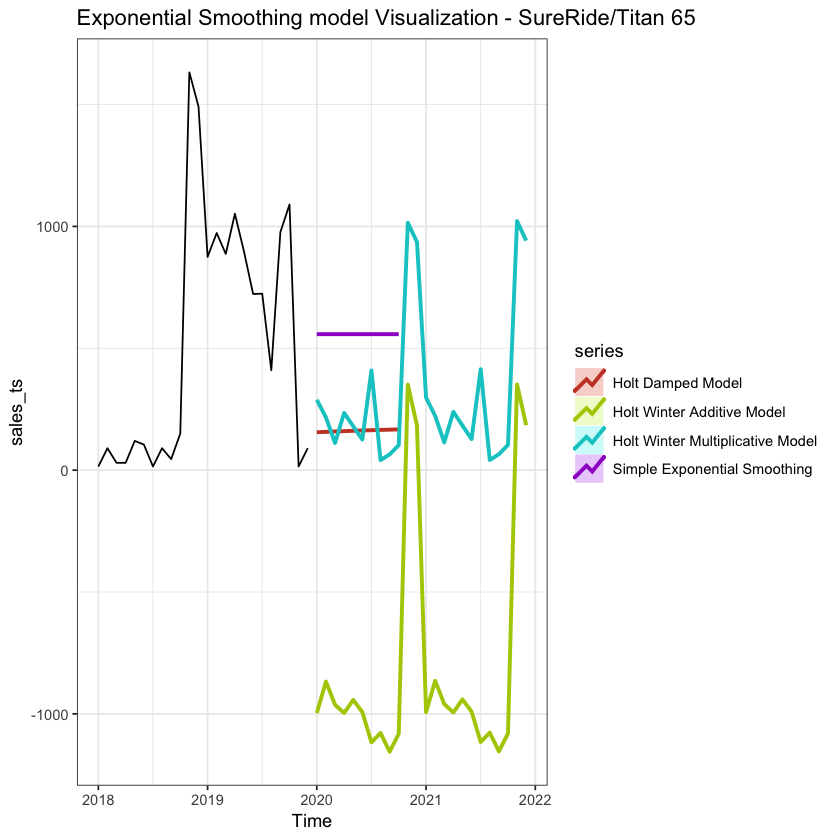

In [30]:
# Visualize forecasts (train & test)
autoplot(sales_ts)+
    autolayer(ses_model_all,series  = 'Simple Exponential Smoothing',PI = F, size = 1.1) +
    autolayer(holt_damp_model_all, series = 'Holt Damped Model', PI = F, size = 1.1)+
    autolayer(hw_additive_all, series = 'Holt Winter Additive Model', PI =F, size = 1.1)+
    autolayer(hw_multiplicative_all, series = 'Holt Winter Multiplicative Model', PI = F, size=1.1)+
labs(title="Exponential Smoothing model Visualization - SureRide/Titan 65")+theme_bw()

### Step10: obtain forecast values on the whole dataset

In [31]:
# obtain predicted value
ses_forecast_all = forecast(ses_model_all)
holt_forecast_all = forecast(holt_damp_model_all)
hw_additive_forecast_all = forecast(hw_additive_all)
hw_multiplicative_forecast_all = forecast(hw_multiplicative_all)

In [32]:
ses_forecast_all

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020       557.8789 -111.5193 1227.277 -465.8772 1581.635
Feb 2020       557.8789 -114.8579 1230.616 -470.9833 1586.741
Mar 2020       557.8789 -118.1801 1233.938 -476.0641 1591.822
Apr 2020       557.8789 -121.4860 1237.244 -481.1201 1596.878
May 2020       557.8789 -124.7760 1240.534 -486.1516 1601.909
Jun 2020       557.8789 -128.0501 1243.808 -491.1590 1606.917
Jul 2020       557.8789 -131.3087 1247.066 -496.1425 1611.900
Aug 2020       557.8789 -134.5519 1250.310 -501.1027 1616.860
Sep 2020       557.8789 -137.7801 1253.538 -506.0397 1621.797
Oct 2020       557.8789 -140.9933 1256.751 -510.9539 1626.712

In [33]:
holt_forecast_all

         Point Forecast      Lo 80     Hi 80      Lo 95    Hi 95
Jan 2020       155.3952  -448.0247  758.8151  -767.4559 1078.246
Feb 2020       157.0672  -582.8523  896.9868  -974.5421 1288.677
Mar 2020       158.6328  -696.2892 1013.5548 -1148.8575 1466.123
Apr 2020       160.0987  -796.1150 1116.3125 -1302.3040 1622.501
May 2020       161.4713  -886.3061 1209.2488 -1440.9660 1763.909
Jun 2020       162.7566  -969.2186 1294.7317 -1568.4500 1893.963
Jul 2020       163.9600 -1046.3840 1374.3039 -1687.1014 2015.021
Aug 2020       165.0867 -1118.8642 1449.0377 -1798.5468 2128.720
Sep 2020       166.1418 -1187.4306 1519.7142 -1903.9685 2236.252
Oct 2020       167.1297 -1252.6643 1586.9236 -2004.2578 2338.517

In [34]:
hw_additive_forecast_all

         Point Forecast     Lo 80     Hi 80     Lo 95     Hi 95
Jan 2020      -996.7738 -2292.968  299.4206 -2979.132  985.5844
Feb 2020      -867.4641 -2489.573  754.6452 -3348.266 1613.3379
Mar 2020      -962.3710 -2855.236  930.4941 -3857.258 1932.5164
Apr 2020      -996.5563 -3126.144 1133.0318 -4253.480 2260.3676
May 2020      -942.7007 -3285.305 1399.9035 -4525.405 2640.0033
Jun 2020      -992.3833 -3530.262 1545.4956 -4873.734 2888.9675
Jul 2020     -1116.8448 -3836.073 1602.3830 -5275.545 3041.8552
Aug 2020     -1078.3557 -3967.623 1810.9112 -5497.108 3340.3967
Sep 2020     -1155.1668 -4205.049 1894.7155 -5819.559 3509.2257
Oct 2020     -1081.8698 -4284.357 2120.6174 -5979.651 3815.9116
Nov 2020       350.7127 -2997.460 3698.8853 -4769.875 5471.3008
Dec 2020       183.4192 -3304.383 3671.2214 -5150.714 5517.5524
Jan 2021      -993.2003 -4616.375 2629.9742 -6534.368 4547.9670
Feb 2021      -864.3491 -4616.971 2888.2733 -6603.490 4874.7916
Mar 2021      -959.6557 -4837.422 2918.1

In [35]:
hw_multiplicative_forecast_all

         Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
Jan 2020      288.56963  -3068.4917  3645.6310  -4845.6127  5422.7519
Feb 2020      216.71510  -2304.4341  2737.8643  -3639.0499  4072.4801
Mar 2020      111.18066  -1182.2408  1404.6021  -1866.9367  2089.2980
Apr 2020      234.61331  -2494.7777  2964.0043  -3939.6300  4408.8567
May 2020      180.10084  -1915.1306  2275.3323  -3024.2792  3384.4809
Jun 2020      125.54534  -1335.0197  1586.1103  -2108.1961  2359.2868
Jul 2020      409.03669  -4349.6534  5167.7268  -6868.7517  7686.8251
Aug 2020       41.21145   -438.2445   520.6674   -692.0532   774.4761
Sep 2020       64.61062   -687.0833   816.3045  -1085.0060  1214.2273
Oct 2020      102.54698  -1090.5259  1295.6199  -1722.1006  1927.1945
Nov 2020     1014.92126 -10793.2882 12823.1307 -17044.1767 19074.0192
Dec 2020      936.10141  -9955.2737 11827.4765 -15720.8194 17593.0222
Jan 2021      297.60957  -3165.1152  3760.3343  -4998.1709  5593.3900
Feb 2021      222.53

### Step 11: obtain the accuracy value for the constructed models

In [36]:
# ses model
ses_accuracy = accuracy(ses_forecast,x=sales_ts) # accuracy on train and test sets
ses_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,319.9643,575.9090,323.3882,39.5017,62.3277,0.3731403,0.5646401,NA
Test set,169.2757,416.9253,384.7956,-378.3796,437.2432,0.4439949,0.1854478,5.096526


In [37]:
# holt damped model
holt_damped_accuracy = accuracy(holt_forecast, x= sales_ts)
holt_damped_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,54.61218,419.4870,186.9155,-62.10137,109.8791,0.2156717,0.01209182,NA
Test set,-263.53705,471.6942,339.5529,-812.97339,820.1582,0.3917918,0.20503181,10.83735


In [38]:
# hw_additive
hw_additive_accuracy = accuracy(hw_additive_forecast, x = sales_ts)
hw_additive_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-82.43019,417.2015,317.7122,-472.9807,487.960,0.3665910,0.4351678,NA
Test set,-744.52359,910.3687,744.5236,-1458.2660,1458.266,0.8590657,0.3775542,20.34745


In [39]:
# hw_multiplicative
hw_multiplicative_accuracy = accuracy(hw_multiplicative_forecast, x = sales_ts)
hw_multiplicative_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-82.43019,417.2015,317.7122,-472.9807,487.960,0.3665910,0.4351678,NA
Test set,-744.52359,910.3687,744.5236,-1458.2660,1458.266,0.8590657,0.3775542,20.34745
